# <u>**Vivarium E. coli**<u/>

This notebook demonstrates features of the processes in the Vivarium *E. coli* model. First, we show distinct features of how the processes work individually. Then we combine the processes in our simulation to demonstrate how they work together. Finally, we run the entire model.

<u>**Future Directions:**</u>
- Demonstrate:
    1. Ecoli master partitioned
    2. Cell division
    3. Vivarium ecoli colonies

<u>**Miscellaneous notes/ideas:**</u>
- consider adding interactive widgets (plotly) - users can click boxes to choose which molecules to plot

In [1]:
# Make sure notebook runs out of vivarium-ecoli directory
import sys, os

# get the path to the notebook, and change working directory
notebook_path = sys.path[0][:sys.path[0].index('notebooks')]
sys.path.append(notebook_path)
os.chdir(sys.path[-1])
cwd = os.getcwd()

## **Load the required components**

### import modules

In [2]:
from vivarium.core.process import Process
from vivarium.core.store import Store
from vivarium.core.engine import Engine, pp
from vivarium.core.composition import simulate_process, simulate_composite
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import plot_variables
from ecoli.processes.registries import topology_registry
import ecoli
import copy

### Load sim_data

This unpickles and `sim_data` object, which holds model parameters from wcEcoli.
`LoadSimData` includes functions to retrieve individual processes' parameters, which can be modified and passed into their respective process models.

In [3]:
from ecoli.library.sim_data import LoadSimData

SIM_DATA_PATH = 'reconstruction/sim_data/kb/simData.cPickle'

load_sim_data = LoadSimData(
            sim_data_path=SIM_DATA_PATH,
            seed=0)

### Get initial state snapshot

`initial_state` is a dict with the initial state of the system -- a snapshot saved from wcEcoli.

In [4]:
from ecoli.composites.ecoli_master import get_state_from_file

INITIAL_STATE_PATH = 'data/wcecoli_t1000.json'

initial_state = get_state_from_file(path=INITIAL_STATE_PATH)

### Helper functions for executing the notebook

In [5]:
schema_keys = Store.schema_keys

def make_port_printout(ports_schema, depth=0, schema_show=5, filler_size=5):
    print_dict = ''
    filler = filler_size * ' '
    for port, schema in ports_schema.items():
        if isinstance(schema, dict):
            schemavars = list(schema.keys())
            if any(var in schemavars for var in schema_keys):
                print_schema = ''
                for k, v in schema.items():
                    print_schema += f'{(depth+1) * filler} {k}: {v}\n'
                print_dict += f'{depth * filler}{port}:\n{print_schema}\n'
            else:
                schema_items = schema.items()
                first_schema = dict(list(schema_items)[:schema_show])
                next_print = make_port_printout(first_schema, depth+1)
                print_dict += f'{port}:\n{next_print}\n'
                if len(schema) > schema_show:
                    print_dict += f'{(depth+1) * filler}'
                    print_dict += f'... skipping {len(schema)-schema_show} schema entries ...'
                    print_dict += f'\n\n'
        else:
            print_dict += f'{filler}{schema}\n'
    return print_dict

def find_increasing(d):
    for key, value in d.items():
        if value[-1] > value[0]:
            return {key: value}
    
def find_decreasing(d):
    for key, value in d.items():
        if value[-1] < value[0]:
            return {key: value}

# **Simulate Processes Individually**


Now we can load in our modular processes individually. For each process, we will:

1. Load in the process and parameters
2. Plot a **toplogy** diagram 
    - The topology is a network that demonstrates how a process connects to its stores (which hold state variables).
3. Display the **ports schema**
     - The port schema defines a systems ports (top-level keys), and the expected behavior of molecules under that port (its *schema*)
     - `*` is a wild card, specifies the schema of everything that can go into the port
4. Simulate the process
5. Demonstrate distinct features of that process

## <u>Complexation<u/>
    
[Complexation Documentation](https://covertlab.github.io/vivarium-coli/reference/api/ecoli.processes.complexation.html)

In [6]:
from ecoli.processes.complexation import Complexation

# load in parameters
cplx_config = load_sim_data.get_complexation_config()
cplx_config['time_step'] = 0.01

# initialize process
complexation = Complexation(cplx_config)

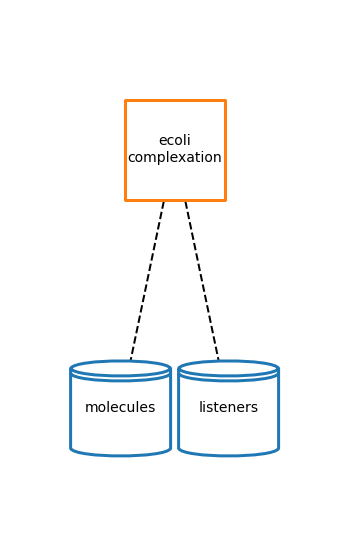

In [7]:
# plot topology
cplx_topology_plot_settings = {
    'buffer': 1,
    'node_labels': {
        'ecoli-complexation': 'ecoli\ncomplexation'
    },
    'show_ports': False,
    'node_size': 10000,
    'dashed_edges': True,
    'node_distance': 4,
}

cplx_topology_fig = plot_topology(complexation, cplx_topology_plot_settings)

In [8]:
# display ports schema
cplx_ports = complexation.ports_schema()
cplx_printout = make_port_printout(cplx_ports)
print(cplx_printout)

molecules:
     1-PFK[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     1-PFK-MONOMER[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     2OXOGLUTARATEDEH-CPLX[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     E1O[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     E2O[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}


     ... skipping 2569 schema entries ...

listeners:
     complexation_events:
           _default: []
           _updater: set
           _emit: True





In [9]:
# tweak initial state
cplx_initial_state = copy.deepcopy(initial_state)
cplx_initial_state['bulk']['6PGLUCONDEHYDROG-MONOMER[c]'] = 1000

# run simulation and retrieve final data
cplx_settings = {
    'total_time': 0.1,
    'initial_state': cplx_initial_state,
    'topology': complexation.topology}

cplx_data = simulate_process(complexation, cplx_settings)


Simulation ID: d55bc216-201a-11ec-a3e2-8c85908ac627
Created: 09/27/2021 at 22:13:36
Completed in 0.188401 seconds


For complexation, let's look at the 6PGLUCONDEHYDROG-MONOMER[c] monomer as it transitions to the 6PGLUCONDEHYDROG-CPLX[c] complex:

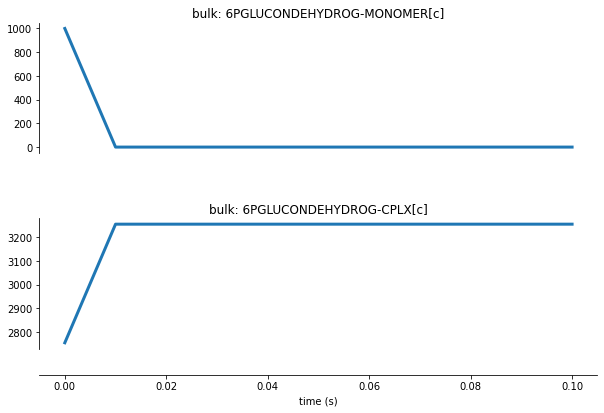

In [10]:
# plot output
cplx_fig = plot_variables(
    cplx_data, 
    variables=[
        ('bulk', '6PGLUCONDEHYDROG-MONOMER[c]'), 
        ('bulk', '6PGLUCONDEHYDROG-CPLX[c]'), 
    ],
    column_width=10, row_height=3, row_padding=0.5)

Here we see 6PGLUCONDEHYDROG-MONOMER[c] getting complexed. This a relatively fast process and consumes all the monomers in a single time step.

## <u>Transcript Initiation<u/>
    
[Transcript Initiation Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.transcript_initiation.html)

In [11]:
from ecoli.processes.transcript_initiation import TranscriptInitiation

# load in parameters
ti_params = load_sim_data.get_transcript_initiation_config()

# initialize process and topology
transcript_initiation = TranscriptInitiation(ti_params)

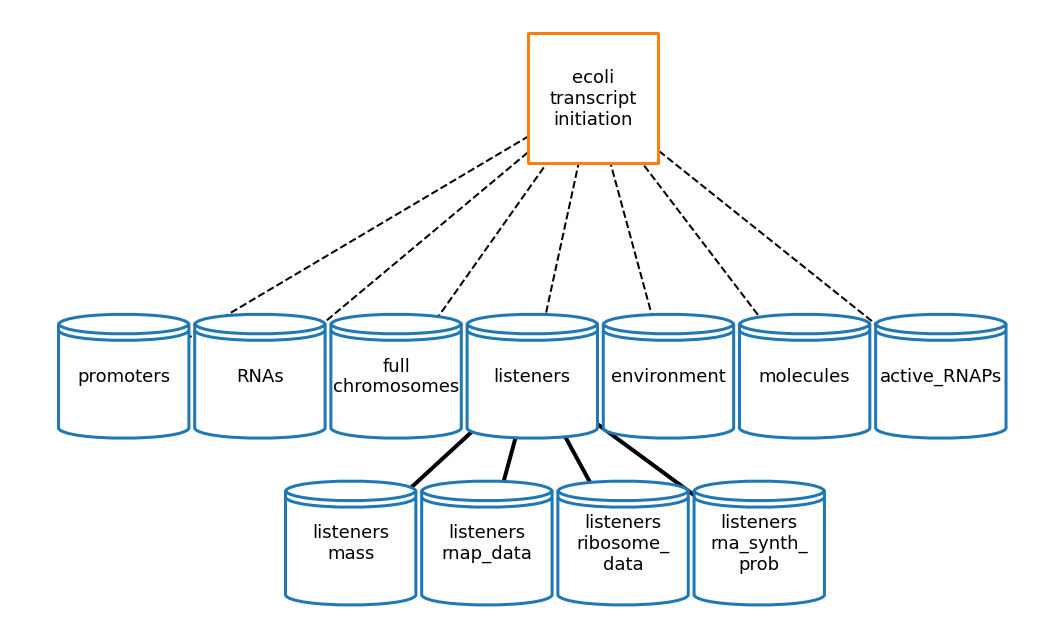

In [12]:
# plot topology
ti_topology_plot_settings = {
    'node_labels': {
        'ecoli-transcript-initiation': 'ecoli\ntranscript\ninitiation',
        'full_chromosomes': 'full\nchromosomes',
        'listeners\nrna_synth_prob': 'listeners\nrna_synth_\nprob',
        'listeners\nribosome_data': 'listeners\nribosome_\ndata',
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-transcript-initiation': (4, 2)}
}

ti_topology_fig = plot_topology(transcript_initiation, ti_topology_plot_settings)

In [13]:
# display ports schema
ti_ports = transcript_initiation.ports_schema()
ti_printout = make_port_printout(ti_ports)
print(ti_printout)

environment:
     media_id:
           _default: 
           _updater: set


molecules:
     APORNAP-CPLX[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}

     GUANOSINE-5DP-3DP[c]:
           _default: 0
           _divider: binomial_ecoli
           _emit: True
           _properties: {'bulk': True}


full_chromosomes:
*:
          unique_index:
                _default: 0



promoters:
*:
          TU_index:
                _default: 0

          coordinates:
                _default: 0

          domain_index:
                _default: 0

          bound_TF:
                _default: 0



RNAs:
*:
          unique_index:
                _default: 0
                _updater: set

          TU_index:
                _default: 0
                _updater: set

          transcript_length:
                _default: 0
                _updater: set
                _emit: True

          is_mRNA:
                _

In [14]:
# run simulation and retrieve final data
ti_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': transcript_initiation.topology}

ti_data = simulate_process(transcript_initiation, ti_settings)


Simulation ID: d5cdfdcc-201a-11ec-a3e2-8c85908ac627
Created: 09/27/2021 at 22:13:38


AttributeError: 'Transcription' object has no attribute 'stable_RNA_elongation_rate'

For Transcript Initiation, we can see from the cell above that each active RNA polymerase molecule is represented by an ID number. Let's analyze how one of these active RNA polymerase molecules functions within this process:

In [ ]:
# plot output
RNAP_ID = list(ti_data['unique']['active_RNAP'].keys())[0] 

ti_fig = plot_variables(
    ti_data, 
    variables=[
        ('unique', 'active_RNAP', RNAP_ID, 'coordinates'),
        ('bulk', 'APORNAP-CPLX[c]')
        ],
    column_width=10, row_height=3, row_padding=0.5)

Here we can see that the coordinates for one RNA polymerase molecule is initialized at time=0 and remains the same throughout the simulation as elongation is not a function of this process. Additionally, we can see that the RNA polymerase molecules (given by APORNAP-CPLX[c]) are getting deleted from the bulk molecules count as they bind to the DNA sequence and are initialized for transcription.

## <u>Transcript Elongation<u/>
    
    
[Transcript Elongation Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.transcript_elongation.html)

In [ ]:
from ecoli.processes.transcript_elongation import TranscriptElongation

# load in parameters
te_params = load_sim_data.get_transcript_elongation_config()

# initialize process and topology
transcript_elongation = TranscriptElongation(te_params)

In [ ]:
# plot topology
te_topology_plot_settings = {
    'node_labels': {
        'ecoli-transcript-elongation': 'ecoli\ntranscript\nelongation',
        'listeners\ntranscript_elongation_listener': '\nlisteners\ntranscript_\nelongation_\nlistener'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-transcript-elongation': (4, 2)}
}

te_topology_fig = plot_topology(transcript_elongation, te_topology_plot_settings)

In [ ]:
# display ports schema
te_ports = transcript_elongation.ports_schema()
te_printout = make_port_printout(te_ports)
print(te_printout)

In [ ]:
# run simulation and retrieve final data
te_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': transcript_elongation.topology}

te_data = simulate_process(transcript_elongation, te_settings)

For Transcript Elongation, we can see from the cell above that each active RNA Polymerase molecule is represented by an ID number. Let's analyze how a few of these active RNA Polymerase molecules function within this process:

In [ ]:
# plot output
te_fig = plot_variables(
    te_data, 
    variables=[
        ('unique', 'active_RNAP', '1266660', 'coordinates'),
        ('unique', 'active_RNAP', '1293463', 'coordinates'),
        ('unique', 'active_RNAP', '1293466', 'coordinates')
        ],
    column_width=10, row_height=3, row_padding=0.5)

Here we can see that the coordinates for these RNA Polymerase molecules are initialized at time=0 but change throughout the simulation. Some polymerase coordinates incease, indicating elongation in one direction, and others decrease, indicating elongation in the opposite direction along the DNA sequence. 

Funadamentally, these changes represent the process of polymerization: as the RNA polymerase molecules travel across the DNA, RNA molecucles are assembled.

## <u>Transcription Factor Binding<u/>
    
[TF Binding Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.tf_binding.html)

In [ ]:
from ecoli.processes.tf_binding import TfBinding

# load in parameters
tfb_params = load_sim_data.get_tf_config()

# initialize process and topology
tf_binding = TfBinding(tfb_params)

tfb_topology = topology_registry.access(tf_binding.name)

In [ ]:
# plot topology
tfb_topology_plot_settings = {
    'node_labels': {
        'ecoli-tf-binding': 'ecoli\ntf binding',
        'listeners\nrna_synth_prob': 'listeners\nrna_synth_\nprob',
        'active_tfs_total': 'active_tfs_\ntotal',
        'inactive_tfs_total': 'inactive_tfs_\ntotal'
    },
    'show_ports': False,
    'node_size': 16000,
    'node_distance': 3.5,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-tf-binding': (2, 2)}
}

tfb_topology_fig = plot_topology(tf_binding, tfb_topology_plot_settings)

In [ ]:
# display ports schema
tfb_ports = tf_binding.ports_schema()
tfb_printout = make_port_printout(tfb_ports)
print(tfb_printout)

In [ ]:
# run simulation and retrieve final data
tfb_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': tfb_topology}

tfb_data = simulate_process(tf_binding, tfb_settings)

In [ ]:
# plot output
tfb_fig_active = plot_variables(
    tfb_data, 
    variables=[
        ('bulk', 'CPLX-125[c]'),
        ('bulk', 'CPLX0-226[c]'),
        ('bulk', 'MONOMER0-162[c]')
        ],
    column_width=10, row_height=3, row_padding=0.5)

## <u>Chromosome Replication<u/>
    
[Chromosome Replication Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.chromosome_replication.html)

In [15]:
from ecoli.processes.chromosome_replication import ChromosomeReplication

# load in parameters
cr_params = load_sim_data.get_chromosome_replication_config()

# initialize process and topology
chromosome_replication = ChromosomeReplication(cr_params)

cr_topology = topology_registry.access(chromosome_replication.name)

In [ ]:
# plot topology
cr_topology_plot_settings = {
    'node_labels': {
        'ecoli-chromosome-replication': 'ecoli\nchromosome\nreplication',
        'replisome_trimers': 'replisome\ntrimers',
        'replisome_monomers': 'replisome\nmonomers',
        'active_replisomes': 'active\nreplisomes',
        'full_chromosomes': 'full\nchromosomes',
        'chromosome_domains': 'chromosome\ndomains',
        'listeners\nreplication_data': 'listeners\nreplication_\ndata'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.5,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-chromosome-replication': (3, 2)}
}

cr_topology_fig = plot_topology(chromosome_replication, cr_topology_plot_settings)

In [ ]:
# display ports schema
cr_ports = chromosome_replication.ports_schema()
cr_printout = make_port_printout(cr_ports)
print(cr_printout)

In [ ]:
# tweak initial state to trigger replication
cr_initial_state = copy.deepcopy(initial_state)
cr_initial_state['listeners']['mass']['cell_mass'] = 2000.0

# run simulation and retrieve final data
cr_settings = {
    'total_time': 100,
    'initial_state': cr_initial_state,
    'topology': cr_topology,
    'emit_step': 10,
    'return_raw_data': True}

cr_data = simulate_process(chromosome_replication, cr_settings)

In [ ]:
cr_data[0.0]['unique']['oriC']

In [ ]:
cr_data[10.0]['unique']['oriC']

Here a new origin of replication (oriC) has formed between time 0 and 10. This indicates the beginning of the chromosome replication process.

## <u>Chromosome Structure<u/>
    
[Chromosome Structure Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.chromosome_structure.html)

In [ ]:
from ecoli.processes.chromosome_structure import ChromosomeStructure

# load in parameters
cs_params = load_sim_data.get_chromosome_structure_config()

# initialize process and topology
chromosome_structure = ChromosomeStructure(cs_params)

cs_topology = topology_registry.access(chromosome_structure.name)

In [ ]:
# plot topology
cs_topology_plot_settings = {
    'node_labels': {
        'ecoli-chromosome-structure': 'ecoli\nchromosome\nstructure',
        'full_chromosomes': 'full\nchromosomes',
        'active_ribosome': 'active\nribosome',
        'chromosome_domains': 'chromosome\ndomains',
        'active_replisomes': 'active\nreplisomes',
        'active_RNAPs': 'active\nRNAPs',
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.5,
    'dashed_edges': True,
    'font_size': 20,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-chromosome-structure': (6, 2)}
}

cs_topology_fig = plot_topology(chromosome_structure, cs_topology_plot_settings)

In [ ]:
# display ports schema
cs_ports = chromosome_structure.ports_schema()
cs_printout = make_port_printout(cs_ports)
print(cs_printout)

In [ ]:
cs_initial_state = copy.deepcopy(initial_state)

# run simulation and retrieve final data
cs_settings = {
    'total_time': 10,
    'initial_state': cs_initial_state,
    'topology': cs_topology,
    'emit_step': 10,
    'return_raw_data': True}

cs_data = simulate_process(chromosome_structure, cs_settings)

## <u>Polypeptide Initiation<u/>
    
[Polypeptide Initiation Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.polypeptide_initiation.html)

In [ ]:
from ecoli.processes.polypeptide_initiation import PolypeptideInitiation

# load in parameters
pi_params = load_sim_data.get_polypeptide_initiation_config()

# initialize process and topology
polypeptide_initiation = PolypeptideInitiation(pi_params)

pi_topology = topology_registry.access(polypeptide_initiation.name)

In [ ]:
# plot topology
pi_topology_plot_settings = {
    'node_labels': {
        'ecoli-polypeptide-initiation': 'ecoli\npolypeptide\ninitiation',
        'active_ribosome': 'active\nribosome'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.5,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-polypeptide-initiation': (3, 2)}
}

pi_topology_fig = plot_topology(polypeptide_initiation, pi_topology_plot_settings)

In [ ]:
# display ports schema
pi_ports = polypeptide_initiation.ports_schema()
pi_printout = make_port_printout(pi_ports)
print(pi_printout)

In [ ]:
# run simulation and retrieve final data
pi_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': pi_topology}

pi_data = simulate_process(polypeptide_initiation, pi_settings)

We can observe the 30S ribosomal subunit ('CPLX0-3953[c]') and 50S ribosomal subunit (CPLX0-3962[c]) molecule counts:

In [ ]:
# plot output
pi_fig = plot_variables(
    pi_data, 
    variables=[
        ('bulk', 'CPLX0-3953[c]'),
        ('bulk', 'CPLX0-3962[c]')
        ],
    column_width=10, row_height=3, row_padding=0.5)

pi_fig.savefig('notebooks/pi_fig.png')
pi_fig.show()

The decrease within the first time step of the simulation demonstrates how active 70S ribosomes are rapidly formed from free 30S and 50S subunits. We can also see how the 30S ribosome subunit (CPLX0-3953[c]) is limiting.

## <u>Polypeptide Elongation<u/>
    
[Polypeptide Elongation Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.polypeptide_elongation.html)

In [16]:
from ecoli.processes.polypeptide_elongation import PolypeptideElongation

# load in parameters
pe_params = load_sim_data.get_polypeptide_elongation_config()

# initialize process and topology
polypeptide_elongation = PolypeptideElongation(pe_params)

pe_topology = topology_registry.access(polypeptide_elongation.name)

In [ ]:
# plot topology
pe_topology_plot_settings = {
    'node_labels': {
        'ecoli-polypeptide-elongation': 'ecoli\npolypeptide\nelongation',
        'uncharged_trna': 'uncharged_\ntrna',
        'uncharged_trna_total': 'uncharged_\ntrna_total',
        'charged_trna_total': 'charged_\ntrna_total',
        'charging_molecules': 'charging_\nmolecules',
        'active_ribosome': 'active_\nribosome',
        'polypeptide_elongation': 'polypeptide\nelongation',
        'ppgpp_reaction_metabolites': 'ppgpp\nreaction\nmetabolites',
        'chromosome_domains': 'chromosome\ndomains',
        'listeners\nreplication_data': 'listeners\nreplication_\ndata',
        'amino_acids_total': 'amino_acids_\ntotal'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-polypeptide-elongation': (7, 1.75)}
}

pe_topology_fig = plot_topology(polypeptide_elongation, pe_topology_plot_settings)

In [ ]:
# display ports schema
pe_ports = polypeptide_elongation.ports_schema()
pe_printout = make_port_printout(pe_ports)
print(pe_printout)

In [ ]:
# run simulation and retrieve final data
pe_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': pe_topology}

pe_data = simulate_process(polypeptide_elongation, pe_settings)

We can see from the cell above that each active ribosome molecule is represented by an ID number. Let's analyze the polypeptide length and the ribosome's position on mRNA of one active ribosome within this process:

In [ ]:
# plot output
RIBOSOME_ID = '1246839'

pe_fig = plot_variables(
    pe_data, 
    variables=[
        ('unique', 'active_ribosome', RIBOSOME_ID, 'pos_on_mRNA'),
        ('unique', 'active_ribosome', RIBOSOME_ID, 'peptide_length')
        ],
    column_width=10, row_height=3, row_padding=0.5)

Here we can see that as the simulation progresses, the ribosome travels along the mRNA strand (as shown by the increasing pos_on_mRNA variable) and polymerization of amino acids into a polypeptide occurs (as shown by the increasing peptide_length variable).

After elongation terminates, we can see an increase in protein counts:

In [ ]:
pe_fig1 = plot_variables(
    pe_data, 
    variables=[
        ('bulk', '6PGLUCONDEHYDROG-MONOMER[c]')
    ],
    column_width=10, row_height=3, row_padding=0.5)

## <u>Protein Degradation<u/>
    
[Polypeptide Degradation Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.protein_degradation.html)

In [17]:
from ecoli.processes.protein_degradation import ProteinDegradation

# load in parameters
pd_params = load_sim_data.get_protein_degradation_config()

# initialize process and topology
protein_degradation = ProteinDegradation(pd_params)

pd_topology = topology_registry.access(protein_degradation.name)

In [ ]:
# plot topology
pd_topology_plot_settings = {
    'buffer': 1,
    'node_labels': {
        'ecoli-protein-degradation': 'ecoli\nprotein\ndegradation'
    },
    'node_distance': 5,
    'show_ports': False,
    'node_size': 10000,
    'dashed_edges': True,
    'coordinates': {'ecoli-protein-degradation': (1.5, 0.5)}
}

pd_topology_fig = plot_topology(protein_degradation, pd_topology_plot_settings)

In [ ]:
# display ports schema
pd_ports = protein_degradation.ports_schema()
pd_printout = make_port_printout(pd_ports)
print(pd_printout)

In [ ]:
# run simulation and retrieve final data
pd_settings = {
    'total_time': 600,
    'initial_state': initial_state,
    'topology': pd_topology,
    'emit_step': 10}

pd_data = simulate_process(protein_degradation, pd_settings)

For protein degradation, let's look at the ARTJ-MONOMER[p] monomer, a protein selected for degradation at this time point, as it degrades into its subcomponents:

In [ ]:
# plot output
pd_fig = plot_variables(
    pd_data, 
    variables=[
        ('bulk', 'ARTJ-MONOMER[p]'),
        ('bulk', 'ASN[c]'),
        ('bulk', 'WATER[c]')
        ],
    column_width=10, row_height=3, row_padding=0.5)

We can see here that as the ARTJ-MONOMER[p] protein degrades, the count for the amino acid asparagine increases and water is consumed.

## <u>RNA Degradation<u/>
    
[RNA Degradation Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.rna_degradation.html)

In [ ]:
from ecoli.processes.rna_degradation import RnaDegradation

# load in parameters
rd_params = load_sim_data.get_rna_degradation_config()

# initialize process and topology
rna_degradation = RnaDegradation(rd_params)

rd_topology = topology_registry.access(rna_degradation.name)

In [ ]:
# plot topology
rd_topology_plot_settings = {
    'node_labels': {
        'ecoli-rna-degradation': 'ecoli\nrna\ndegradation',
        'fragmentMetabolites': 'fragment\nMetabolites',
        'listeners\nrna_degradation_listener': '\nlisteners\nrna_\ndegradation_\nlistener',
        'active_ribosome': 'active_\nribosome'
    },
    'show_ports': False,
    'node_size': 17000,
    'node_distance': 3.3,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-rna-degradation': (7, 1.75)}
}

rd_topology_fig = plot_topology(rna_degradation, rd_topology_plot_settings)

In [ ]:
# display ports schema
rd_ports = rna_degradation.ports_schema()
rd_printout = make_port_printout(rd_ports)
print(rd_printout)

In [ ]:
# run simulation and retrieve final data
rd_settings = {
    'total_time': 100,
    'initial_state': initial_state,
    'topology': rd_topology}

rd_data = simulate_process(rna_degradation, rd_settings)

For RNA degradation, let's look at a few RNA molecules as the simulation runs:

In [ ]:
# plot output
rd_fig = plot_variables(
    rd_data, 
    variables=[
        ('bulk', 'RNA0-300[c]'),
        ('bulk', 'RNA0-301[c]'),
        ('bulk', 'WATER[c]')
        ],
    column_width=10, row_height=3, row_padding=0.5)

RNAs are selected and degraded by endoRNases, and non-functional RNA fragments are digested through exoRNases. During the process water is consumed, and nucleotides, pyrophosphate and protons are released.

## <u>Two Component System<u/>
    
[Two Component System Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.two_component_system.html)

In [ ]:
from ecoli.processes.two_component_system import TwoComponentSystem

# load in parameters
tcs_params = load_sim_data.get_two_component_system_config()
    
# initialize process and topology
two_component_system = TwoComponentSystem(tcs_params)

tcs_topology = topology_registry.access(two_component_system.name)

In [ ]:
# plot topology
tcs_topology_plot_settings = {
    'node_labels': {
        'ecoli-two-component-system': 'ecoli two\ncomponent\nsystem'
    },
    'show_ports': False,
    'node_size': 16000,
    'node_distance': 5.0,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-two-component-system': (1.35, 1)}
}

tcs_topology_fig = plot_topology(two_component_system, tcs_topology_plot_settings)

In [ ]:
# display ports schema
tcs_ports = two_component_system.ports_schema()
tcs_printout = make_port_printout(tcs_ports)
print(tcs_printout)

In [ ]:
# tweak initial state??
tcs_initial_state = copy.deepcopy(initial_state)

# run simulation and retrieve final data
tcs_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': tcs_topology}

tcs_data = simulate_process(two_component_system, tcs_settings)

In [ ]:
tcs_data

Phosphate groups are transferred from histidine kinases to response regulators and back in response to counts of ligand stimulants

In [ ]:
# # plot output
# tcs_fig = plot_variables(
#     tcs_data, 
#     variables=[
#         ],
#     column_width=10, row_height=3, row_padding=0.5)

## <u>Equilibrium<u/>
    
[Equilibrium Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.equilibrium.html)

In [ ]:
from ecoli.processes.equilibrium import Equilibrium

# load in parameters
eq_params = load_sim_data.get_equilibrium_config()

# initialize process and topology
equilibrium = Equilibrium(eq_params)

eq_topology = topology_registry.access(equilibrium.name)

In [ ]:
# plot topology
eq_topology_plot_settings = {
    'node_labels': {
        'ecoli-equilibrium': 'ecoli\nequilibrium',
        'listeners\nequilibrium_listener': '\nlisteners\nequilibrium\nlistener'
    },
    'show_ports': False,
    'node_size': 14000,
    'node_distance': 5.0,
    'dashed_edges': True,
    'font_size': 18,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-equilibrium': (1.5, 1.25)}
}

eq_topology_fig = plot_topology(equilibrium, eq_topology_plot_settings)

In [ ]:
# display ports schema
eq_ports = equilibrium.ports_schema()
eq_printout = make_port_printout(eq_ports)
print(eq_printout)

In [ ]:
# run simulation and retrieve final data
eq_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': eq_topology}

eq_data = simulate_process(equilibrium, eq_settings)

In [ ]:
# # plot output
# eq_fig = plot_variables(
#     eq_data, 
#     variables=[
#         ],
#     column_width=10, row_height=3, row_padding=0.5)

## <u>Metabolism<u/>

[Metabolism Documentation](https://covertlab.github.io/vivarium-ecoli/reference/api/ecoli.processes.metabolism.html)

In [ ]:
from ecoli.processes.metabolism import Metabolism


load_sim_data.sim_data.process.metabolism

In [ ]:
load_sim_data.sim_data.process.metabolism.linked_metabolites

In [ ]:
# load in parameters
meta_params = load_sim_data.get_metabolism_config()

# from vivarium.core.engine import pf
# print(pf(meta_params))

# initialize process and topology
metabolism = Metabolism(meta_params)

# meta_topology = topology_registry.access(metabolism.name)

In [ ]:
# plot topology
meta_topology_plot_settings = {
    'node_labels': {
        'ecoli-metabolism': 'ecoli\nmetabolism',
        'kinetics_enzymes': 'kinetics\nenzymes',
        'kinetics_substrates': 'kinetics\nsubstrates',
        'environment\nexchange_data': '\nenvironment\nexchange_\ndata',
        'listeners\nenzyme_kinetics': '\nlisteners\nenzyme_\nkinetics',
        'polypeptide_elongation': 'polypeptide_\nelongation'
    },
    'show_ports': False,
    'node_size': 15000,
    'node_distance': 3.2,
    'dashed_edges': True,
    'font_size': 17,
    'graph_format': 'hierarchy',
    'coordinates': {'ecoli-metabolism': (4.5, 2)}
}

meta_topology_fig = plot_topology(metabolism, meta_topology_plot_settings)

In [ ]:
# display ports schema
meta_ports = metabolism.ports_schema()
meta_printout = make_port_printout(meta_ports)
print(meta_printout)

In [ ]:
# run simulation and retrieve final data
meta_settings = {
    'total_time': 10,
    'initial_state': initial_state,
    'topology': meta_topology}

meta_data = simulate_process(metabolism, meta_settings)

In [ ]:
reaction_fluxes = meta_data['listeners']['fba_results']['reactionFluxes']
del reaction_fluxes[0]

In [ ]:
# generate time series
reaction_fluxes_time_series = {}

for fluxes in reaction_fluxes:
    for reaction_id, flux in enumerate(fluxes):
        if reaction_id not in reaction_fluxes_time_series:
            reaction_fluxes_time_series[reaction_id] = []
        reaction_fluxes_time_series[reaction_id].append(flux)

In [ ]:
# plot figure
import matplotlib.pyplot as plt

fig = plt.figure()

for reaction_id, time_series in reaction_fluxes_time_series.items():
    plt.plot(time_series)
    
plt.title('Reaction Fluxes')